# Advanced models

Notebook to showcase the evaluatio of all models within our pipeline

In [1]:
from ift6758.pipeline import ExperimentPipeline, DEFAULT_TRANSFORMATIONS
from ift6758.pipeline.plots import plot_all

from xgboost import XGBClassifier

import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
df = ExperimentPipeline.get_data('../data/tabular', transformations=DEFAULT_TRANSFORMATIONS)
df.head()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing


,game_starttime,game_endtime,game_id,datetime,offense_team_id,offense_team_name,offense_team_tricode,goal,x_coords,y_coords,period,period_time,goalie_id,goalie_name,shooter_id,shooter_name,shot_type,prev_type,prev_x_coords,prev_y_coords,prev_datetime,empty_net,strength_shorthand,strength_even,strength_powerplay,season,shot_angle,shot_distance,game_secs,time_lapsed_prev_event_in_seconds,dist_prev_event,rebound,angle_change,speed
0,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:19:59Z,10,Toronto Maple Leafs,TOR,0,77.0,-5.0,1,01:11,8467950,Craig Anderson,8478483,Mitchell Marner,Wrist Shot,Blocked Shot,-61.0,11.0,2016-10-12T23:19:59Z,False,0.0,0.0,0.0,20162017,67.380135,13.000000,71,0,138.924440,False,0.0,-1.000000
1,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:21:41Z,9,Ottawa Senators,OTT,0,86.0,13.0,1,02:53,8475883,Frederik Andersen,8467967,Chris Kelly,Wrist Shot,Giveaway,54.0,-5.0,2016-10-12T23:21:41Z,False,0.0,0.0,0.0,20162017,12.994617,13.341664,173,0,36.715120,False,0.0,-1.000000
2,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:23:17Z,9,Ottawa Senators,OTT,0,23.0,-38.0,1,04:01,8475883,Frederik Andersen,8476879,Cody Ceci,Wrist Shot,Missed Shot,-72.0,0.0,2016-10-12T23:22:59Z,False,0.0,0.0,0.0,20162017,60.068488,76.157731,241,18,102.318131,False,0.0,5.684341
3,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:24:02Z,9,Ottawa Senators,OTT,0,33.0,-15.0,1,04:46,8475883,Frederik Andersen,8474578,Erik Karlsson,Slap Shot,Missed Shot,77.0,-2.0,2016-10-12T23:23:43Z,False,0.0,0.0,0.0,20162017,75.004921,57.974132,286,19,45.880279,False,0.0,2.414752
4,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,2016020001,2016-10-12T23:27:30Z,10,Toronto Maple Leafs,TOR,0,34.0,-28.0,1,06:46,8467950,Craig Anderson,8475716,Martin Marincin,Wrist Shot,Hit,47.0,34.0,2016-10-12T23:27:15Z,False,0.0,0.0,0.0,20162017,63.019769,61.717096,406,15,63.348244,False,0.0,4.223216


## Experiments

In [3]:
# FOR COMET LOGGING
import os
from getpass import getpass

os.environ['COMET_API_KEY'] = getpass()

## XGBoost

### Limited Features

In [4]:
pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=['shot_distance', 'shot_angle'],
    target_column='goal',
    pipeline_steps=[
        (
            'xgb_model',
            XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
            )
        ),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[{
        'xgb_model__objective':['binary:logistic'],
        'xgb_model__learning_rate': [0.15],
        'xgb_model__max_depth': [4],
        'xgb_model__min_child_weight': [1],
        'xgb_model__n_estimators': [100],
    }],
    metric='accuracy',
    enable_comet=True
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/williamglazer/hockeyanalysis/40a21fe3ba594bc8a3dd9ddbee10ddc1



fetching dataframes from ../data/tabular


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits


COMET WARNING: You must install graphviz to plot tree


[CV 1/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.906 total time=   5.2s
[CV 2/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.906 total time=   4.8s
[CV 3/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.906 total time=   4.9s
[CV 4/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.906 total time=   5.3s
[CV 5/5] END xgb_model__learning_rate=0.15, xgb_model__max_depth=4, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.906 total time=   5.3s


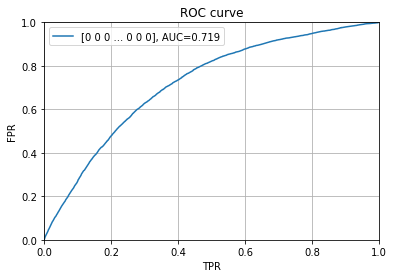

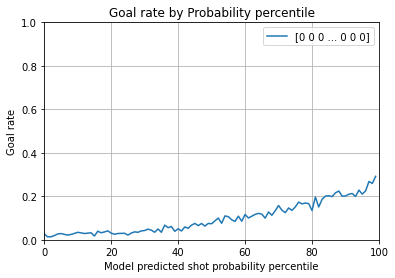

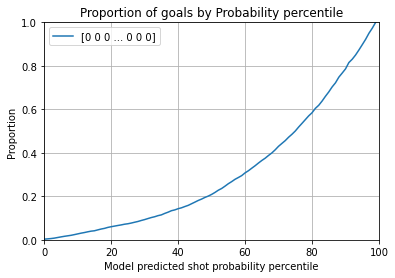

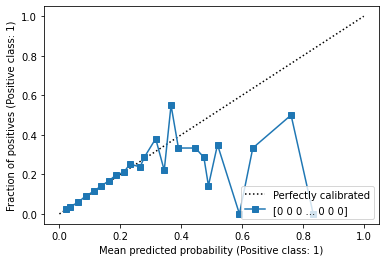

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/williamglazer/hockeyanalysis/40a21fe3ba594bc8a3dd9ddbee10ddc1
COMET INFO:   Metrics:
COMET INFO:     best_model_valid_accuracy : 0.9022239927945405
COMET INFO:     best_model_valid_f1       : 0.0031785272823591734
COMET INFO:     best_model_valid_roc_auc  : 0.7189259688999612
COMET INFO:   Parameters:
COMET INFO:     begin_iteration         : 0
COMET INFO:     best_parameters         : {'xgb_model__learning_rate': 0.15, 'xgb_model__max_depth': 4, 'xgb_model__min_child_weight': 1, 'xgb_model__n_estimators': 100, 'xgb_model__objective': 'binary:logistic'}
COMET INFO:     dataset_transformations : ['mirror_coordinates', 'append_shot_angle', 'append_shot_distance', 'replace_nan_by_0', 'append_game_secs', 'append_time_lapse_prev', 'append_dist_prev', 

In [5]:
pipeline.run()

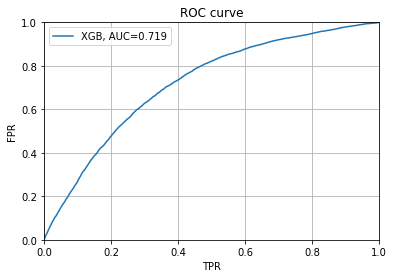

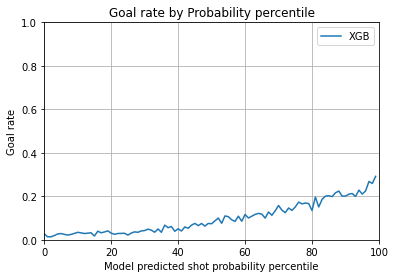

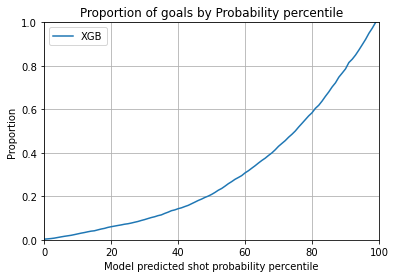

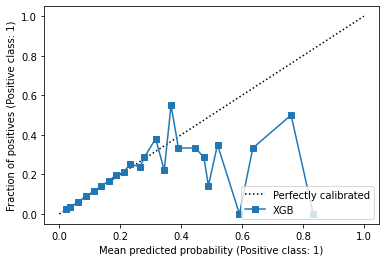

In [6]:
plot_all([pipeline.dataset['y_valid']], [pipeline.get_probas('valid')], ['XGB'])

### All features

In [7]:
features = [
    'shot_distance', 
    'shot_angle', 
    'speed',
    'angle_change',
    'rebound', 
    'dist_prev_event', 
    'time_lapsed_prev_event_in_seconds', 
    'game_secs'
]

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=features,
    target_column='goal',
    pipeline_steps=[
        (
            'xgb_model',
            XGBClassifier(
                objective='binary:logloss',
            )
        ),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[{
        'xgb_model__objective':['binary:logistic'],
        'xgb_model__learning_rate': [0.2, 0.01],
        'xgb_model__max_depth': [3, 6, 10],
        'xgb_model__min_child_weight': [1],
        'xgb_model__n_estimators': [100],
        'xgb_model__eval_metric': ['logloss']
    }],
    metric='roc_auc',
    enable_comet=True
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/williamglazer/hockeyanalysis/1c85a5219e674091b97fcf33ceec5b3d

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file


fetching dataframes from ../data/tabular


COMET WARNING: Unknown error retrieving Conda information


applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.751 total time=  11.5s
[CV 2/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.749 total time=  24.2s
[CV 3/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, x

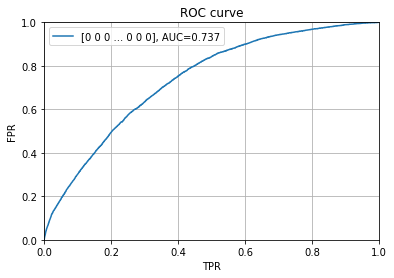

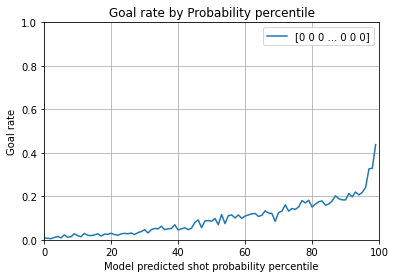

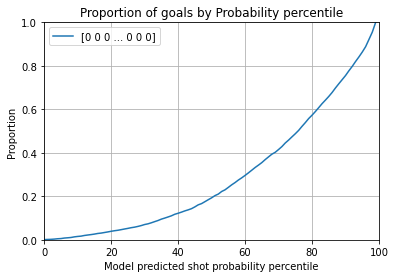

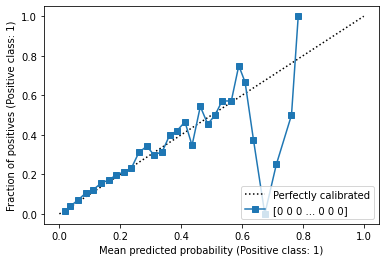

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/williamglazer/hockeyanalysis/1c85a5219e674091b97fcf33ceec5b3d
COMET INFO:   Metrics:
COMET INFO:     best_model_valid_accuracy : 0.9024664842207365
COMET INFO:     best_model_valid_f1       : 0.01676270298585647
COMET INFO:     best_model_valid_roc_auc  : 0.7371248049310138
COMET INFO:   Parameters:
COMET INFO:     begin_iteration         : 0
COMET INFO:     best_parameters         : {'xgb_model__eval_metric': 'logloss', 'xgb_model__learning_rate': 0.2, 'xgb_model__max_depth': 3, 'xgb_model__min_child_weight': 1, 'xgb_model__n_estimators': 100, 'xgb_model__objective': 'binary:logistic'}
COMET INFO:     dataset_transformations : ['mirror_coordinates', 'append_shot_angle', 'append_shot_distance', 'replace_nan_by_0', 'append_game_secs', 'append_time

In [8]:
pipeline.run()

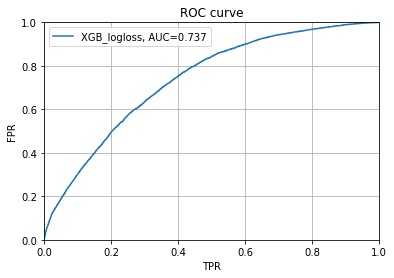

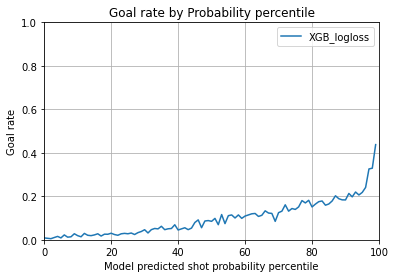

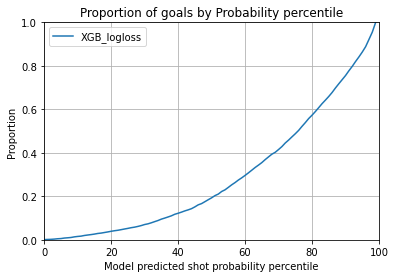

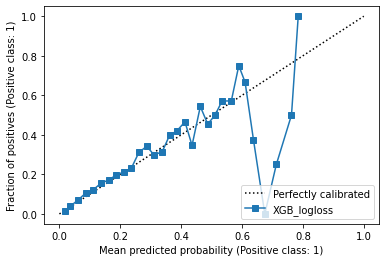

In [9]:
plot_all([pipeline.dataset['y_valid']], [pipeline.get_probas('valid')], ['XGB_logloss'])

In [10]:
pipeline.grid.best_params_

{'xgb_model__eval_metric': 'logloss',
 'xgb_model__learning_rate': 0.2,
 'xgb_model__max_depth': 3,
 'xgb_model__min_child_weight': 1,
 'xgb_model__n_estimators': 100,
 'xgb_model__objective': 'binary:logistic'}

### Feature Selection

In [11]:
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

def plot_feature_importance(features: list[str]):
    X = pipeline.dataset['x_train'][features]
    y = pipeline.dataset['y_train']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    xgb_model = XGBClassifier(objective='binary:logistic', learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100)
    xgb_model.fit(X_train, y_train)

    print("F1", f1_score(y_test, xgb_model.predict(X_test)))
    print("AUC", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

    plot_importance(xgb_model)
    pyplot.show()

F1 0.03415369161225515
AUC 0.750250967656582


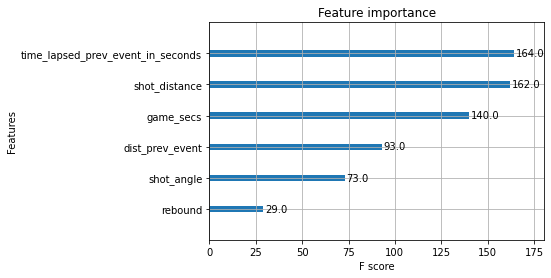

In [12]:
plot_feature_importance(
    ['shot_distance', 'shot_angle', 'rebound', 'dist_prev_event', 'time_lapsed_prev_event_in_seconds', 'game_secs']
)

F1 0.03208422108033588
AUC 0.7457085383165922


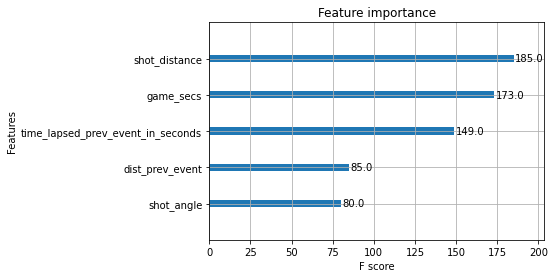

In [13]:
plot_feature_importance(
    ['shot_distance', 'shot_angle', 'dist_prev_event', 'time_lapsed_prev_event_in_seconds', 'game_secs']
)

F1 0.01561531788325691
AUC 0.7305132005181288


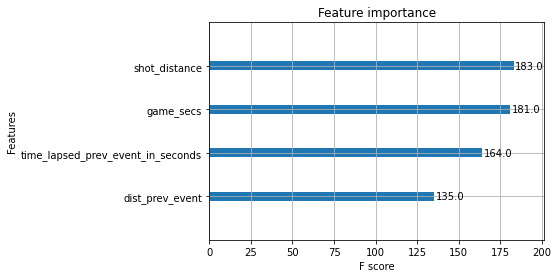

In [14]:
plot_feature_importance(
    ['shot_distance', 'dist_prev_event', 'time_lapsed_prev_event_in_seconds', 'game_secs']
)

our AUC notably drops when we remove this feature, we will stick with 5 features

In [15]:
features = ['shot_distance', 'shot_angle', 'dist_prev_event', 'time_lapsed_prev_event_in_seconds', 'game_secs']

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=features,
    target_column='goal',
    pipeline_steps=[
        (
            'xgb_model',
            XGBClassifier(
                objective='binary:logistic',
            )
        ),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[{
        'xgb_model__objective':['binary:logistic'],
        'xgb_model__learning_rate': [0.2],
        'xgb_model__max_depth': [3],
        'xgb_model__min_child_weight': [1],
        'xgb_model__n_estimators': [100],
        'xgb_model__eval_metric': ['logloss']
    }],
    metric='roc_auc',
    enable_comet=True
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/williamglazer/hockeyanalysis/857cdd44f44e4f0b8ab33f4f1014683e



fetching dataframes from ../data/tabular


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
applying replace_nan_by_0_2
done with preprocessing
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.748 total time=   2.8s
[CV 2/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xgb_model__objective=binary:logistic;, score=0.747 total time=   5.8s
[CV 3/5] END xgb_model__eval_metric=logloss, xgb_model__learning_rate=0.2, xgb_model__max_depth=3, xgb_model__min_child_weight=1, xgb_model__n_estimators=100, xg

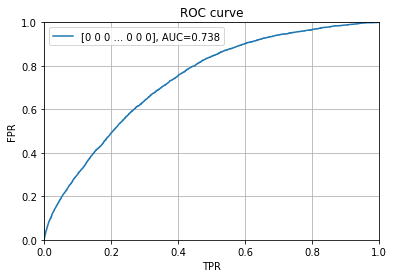

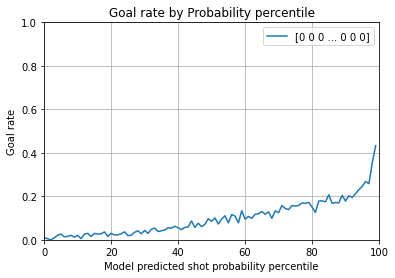

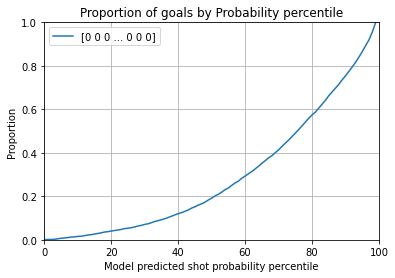

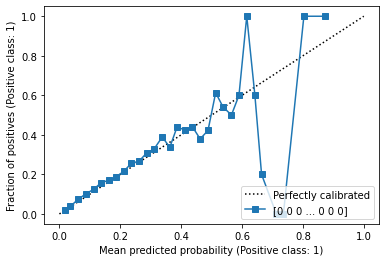

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/williamglazer/hockeyanalysis/857cdd44f44e4f0b8ab33f4f1014683e
COMET INFO:   Metrics:
COMET INFO:     best_model_valid_accuracy : 0.9025704091176776
COMET INFO:     best_model_valid_f1       : 0.017467248908296942
COMET INFO:     best_model_valid_roc_auc  : 0.7379956132245282
COMET INFO:   Parameters:
COMET INFO:     begin_iteration         : 0
COMET INFO:     best_parameters         : {'xgb_model__eval_metric': 'logloss', 'xgb_model__learning_rate': 0.2, 'xgb_model__max_depth': 3, 'xgb_model__min_child_weight': 1, 'xgb_model__n_estimators': 100, 'xgb_model__objective': 'binary:logistic'}
COMET INFO:     dataset_transformations : ['mirror_coordinates', 'append_shot_angle', 'append_shot_distance', 'replace_nan_by_0', 'append_game_secs', 'append_tim

In [16]:
pipeline.run()

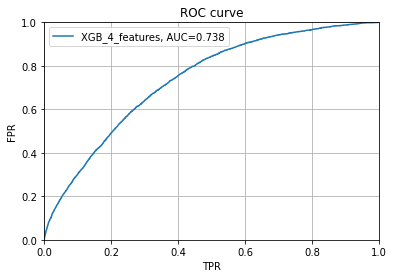

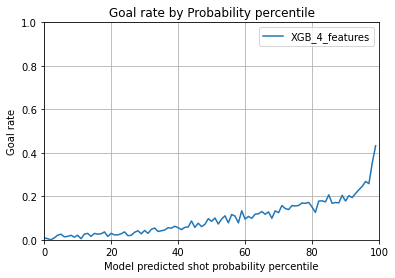

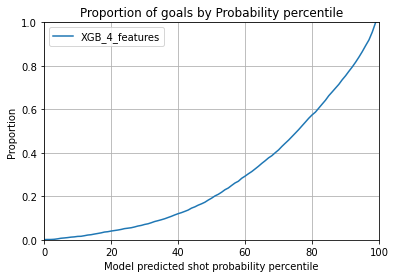

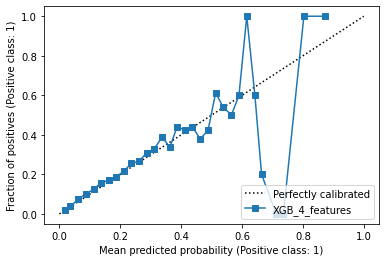

In [18]:
plot_all([pipeline.dataset['y_valid']], [pipeline.get_probas('valid')], ['XGB_4_features'])